# Imports

In [1]:
!pip install albumentations

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import cv2
from skimage.exposure import equalize_adapthist
from skimage.morphology import white_tophat, disk
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix

2025-05-30 22:28:39.410989: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748644119.655882      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748644119.772227      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
try:
    import albumentations as A
except ImportError:
    !pip install albumentations
    import albumentations as A

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [5]:
# Disable TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Configuration

In [6]:
TOPHAT_KERNEL_RADIUS = 15
AHE_CLIP_LIMIT = 0.02
INPUT_SIZE = 512
NUM_CLASSES = 1
BATCH_SIZE = 8  # Tăng lên để training ổn định hơn
EPOCHS = 100
LEARNING_RATE = 3e-4  # Tăng learning rate
CLAHE_CLIP_LIMIT = 2.0
GAUSSIAN_BLUR_KERNEL = 5

# Data Paths

In [7]:
root_data = '/kaggle/input/retinal-vessel-segmentation'
exts = ('jpg', 'JPG', 'png', 'PNG', 'tif', 'gif', 'ppm')

# Training data
input_data_train = os.path.join(root_data, 'DRIVE/training/images')
images_train = sorted([
    os.path.join(input_data_train, fname)
    for fname in os.listdir(input_data_train)
    if fname.endswith(exts) and not fname.startswith(".")
])

target_data_train = os.path.join(root_data, 'DRIVE/training/1st_manual')
masks_train = sorted([
    os.path.join(target_data_train, fname)
    for fname in os.listdir(target_data_train)
    if fname.endswith(exts) and not fname.startswith(".")
])

# Test data
input_data_test = os.path.join(root_data, 'DRIVE/test/images')
images_test = sorted([
    os.path.join(input_data_test, fname)
    for fname in os.listdir(input_data_test)
    if fname.endswith(exts) and not fname.startswith(".")
])

# FIXED: Sử dụng ground truth thay vì mask
target_data_test = os.path.join(root_data, 'DRIVE/test/1st_manual')  # THAY ĐỔI
if not os.path.exists(target_data_test):
    target_data_test = os.path.join(root_data, 'DRIVE/test/mask')

masks_test = sorted([
    os.path.join(target_data_test, fname)
    for fname in os.listdir(target_data_test)
    if fname.endswith(exts) and not fname.startswith(".")
])

print("Number of training samples (images, masks):", len(images_train), len(masks_train))
print("Number of test samples (images, masks):", len(images_test), len(masks_test))


Number of training samples (images, masks): 20 20
Number of test samples (images, masks): 20 20


#  1. Tiền xử lý ảnh 

In [8]:
def enhanced_preprocess_image(image_path):
    """FIXED preprocessing function"""
    try:
        img_pil = Image.open(image_path).convert('RGB')
        img_color = np.array(img_pil)
    except Exception as e:
        print(f"Error reading image {image_path}: {e}")
        return None

    # Extract green channel
    img_green = img_color[:, :, 1]
    
    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=CLAHE_CLIP_LIMIT, tileGridSize=(8,8))
    img_clahe = clahe.apply(img_green)
    
    # Convert to float
    img_float = img_clahe.astype(np.float32) / 255.0
    
    # Apply AHE
    try:
        img_ahe = equalize_adapthist(img_float, clip_limit=AHE_CLIP_LIMIT)
    except Exception as e:
        print(f"Error during AHE for {image_path}: {e}")
        img_ahe = img_float
    
    # Apply morphological top-hat
    try:
        selem = disk(TOPHAT_KERNEL_RADIUS)
        img_complement = 1.0 - img_ahe
        img_tophat = white_tophat(img_complement, selem)
    except Exception as e:
        print(f"Error during Top-Hat for {image_path}: {e}")
        img_tophat = img_ahe
    
    # FIXED: Normalize to [0,1] range
    img_normalized = (img_tophat - img_tophat.min()) / (img_tophat.max() - img_tophat.min() + 1e-8)
    
    return img_normalized

In [9]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    """Dice loss function"""
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice

def combined_loss(y_true, y_pred, alpha=0.3):
    """Combined BCE + Dice loss"""
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return alpha * bce + (1 - alpha) * dice

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """Dice coefficient metric"""
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    return (2. * intersection + smooth) / (union + smooth)

In [10]:
def get_augmentation_pipeline():
    """FIXED: Simpler, more reliable augmentation"""
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
    ])

# ===== FIXED: Simpler U-Net model =====
def build_unet(input_shape=(INPUT_SIZE, INPUT_SIZE, 1)):
    """FIXED: Simpler U-Net without attention"""
    inputs = layers.Input(input_shape)
    
    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # Bottleneck
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    
    # Decoder
    up6 = layers.concatenate([layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)
    
    up7 = layers.concatenate([layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)
    
    up8 = layers.concatenate([layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)
    
    up9 = layers.concatenate([layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)
    
    # Output
    conv10 = layers.Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=[inputs], outputs=[conv10])
    return model

# 2. Tạo dataset từ các Patch 

In [11]:
def create_image_dataset(image_paths, mask_paths, input_size=INPUT_SIZE, augment=True):
    """FIXED dataset creation with proper validation"""
    images = []
    masks = []
    augmentation = get_augmentation_pipeline() if augment else None
    
    for img_path, mask_path in zip(image_paths, mask_paths):
        # Load and preprocess image
        img_preprocessed = enhanced_preprocess_image(img_path)
        if img_preprocessed is None:
            continue
            
        # Load mask
        try:
            mask_pil = Image.open(mask_path).convert('L')
            mask = np.array(mask_pil)
            # FIXED: Proper mask normalization
            mask_binary = (mask > 127).astype(np.float32)
        except Exception as e:
            print(f"Error reading mask {mask_path}: {e}")
            continue
        
        # Resize
        img_resized = cv2.resize(img_preprocessed, (input_size, input_size))
        mask_resized = cv2.resize(mask_binary, (input_size, input_size))
        
        # FIXED: Ensure mask is still binary after resize
        mask_resized = (mask_resized > 0.5).astype(np.float32)
        
        # Add channel dimension
        img_resized = np.expand_dims(img_resized, axis=-1)
        mask_resized = np.expand_dims(mask_resized, axis=-1)
        
        images.append(img_resized)
        masks.append(mask_resized)
        
        # FIXED: Reduced augmentation to avoid overfitting
        if augment and augmentation:
            try:
                augmented = augmentation(image=img_resized[:,:,0], mask=mask_resized[:,:,0])
                aug_img = np.expand_dims(augmented['image'], axis=-1)
                aug_mask = np.expand_dims(augmented['mask'], axis=-1)
                
                # Ensure augmented mask is binary
                aug_mask = (aug_mask > 0.5).astype(np.float32)
                
                images.append(aug_img)
                masks.append(aug_mask)
            except Exception as e:
                print(f"Augmentation failed: {e}")
                continue
    
    X = np.array(images, dtype=np.float32)
    y = np.array(masks, dtype=np.float32)
    
    print(f"Dataset created: {X.shape}, mask range: [{y.min():.3f}, {y.max():.3f}]")
    print(f"Positive pixels ratio: {np.mean(y):.4f}")
    
    return X, y

# 3. Huấn luyện mô hình 1 

In [12]:
def train_improved_model(images_train, masks_train):
    """FIXED training with better validation split"""
    print("Creating training dataset...")
    X_all, y_all = create_image_dataset(images_train, masks_train, augment=True)
    
    # FIXED: Better validation split
    indices = np.arange(len(X_all))
    np.random.shuffle(indices)
    
    split_idx = int(0.85 * len(X_all))  # 85% train, 15% val
    train_indices = indices[:split_idx]
    val_indices = indices[split_idx:]
    
    X_train, y_train = X_all[train_indices], y_all[train_indices]
    X_val, y_val = X_all[val_indices], y_all[val_indices]
    
    print(f"Training data shape: {X_train.shape}, {y_train.shape}")
    print(f"Validation data shape: {X_val.shape}, {y_val.shape}")
    
    # Build model
    model = build_unet()
    
    # FIXED: Better optimizer and compilation
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999)
    model.compile(
        optimizer=optimizer,
        loss=combined_loss,
        metrics=[dice_coefficient, 'accuracy']
    )
    
    print("Model architecture:")
    model.summary()
    
    # FIXED: Better callbacks
    callbacks = [
        ModelCheckpoint(
            '/kaggle/working/best_vessel_model.keras',
            monitor='val_dice_coefficient',
            mode='max',
            save_best_only=True,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_dice_coefficient',
            mode='max',
            patience=15,  # Tăng patience
            verbose=1,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.7,
            patience=7,
            min_lr=1e-7,
            verbose=1
        )
    ]
    
    print("Starting training...")
    history = model.fit(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1,
        shuffle=True
    )
    
    return model, history


In [13]:
def segment_full_image(image_path, model, input_size=INPUT_SIZE):
    """FIXED segmentation with better post-processing"""
    img_preprocessed = enhanced_preprocess_image(image_path)
    if img_preprocessed is None:
        return None, None
    
    original_shape = img_preprocessed.shape
    
    # Resize and predict
    img_resized = cv2.resize(img_preprocessed, (input_size, input_size))
    img_input = np.expand_dims(np.expand_dims(img_resized, axis=-1), axis=0)
    
    prediction = model.predict(img_input, verbose=0)
    
    # Resize back to original
    pred_resized = cv2.resize(prediction[0, :, :, 0], (original_shape[1], original_shape[0]))
    
    # FIXED: Better thresholding
    binary_mask = (pred_resized > 0.3).astype(np.uint8) * 255  # Giảm threshold
    
    return binary_mask, pred_resized

# 4. Huấn luyện mô hình 2

In [14]:
print("\n=== TRAINING IMPROVED MODEL ===")
model, history = train_improved_model(images_train, masks_train)


=== TRAINING IMPROVED MODEL ===
Creating training dataset...
Dataset created: (40, 512, 512, 1), mask range: [0.000, 1.000]
Positive pixels ratio: 0.0861
Training data shape: (34, 512, 512, 1), (34, 512, 512, 1)
Validation data shape: (6, 512, 512, 1), (6, 512, 512, 1)


I0000 00:00:1748644155.933593      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 512, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 128)  │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 256)  │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 256)  │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 64, 64, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 32, 32, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 64, 64, 512)    │      2,097,664 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 64, 1024)   │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

Starting training...
Epoch 1/100


I0000 00:00:1748644166.578118      69 service.cc:148] XLA service 0x7df07000ae80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748644166.579118      69 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748644167.507978      69 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748644225.384424      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8829 - dice_coefficient: 0.1431 - loss: 0.8049   
Epoch 1: val_dice_coefficient improved from -inf to 0.14311, saving model to /kaggle/working/best_vessel_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 109s 10s/step - accuracy: 0.8855 - dice_coefficient: 0.1431 - loss: 0.8047 - val_accuracy: 0.9078 - val_dice_coefficient: 0.1431 - val_loss: 0.7910 - learning_rate: 3.0000e-04
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.9168 - dice_coefficient: 0.1219 - loss: 0.7932
Epoch 2: val_dice_coefficient did not improve from 0.14311
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step - accuracy: 0.9165 - dice_coefficient: 0.1201 - loss: 0.7924 - val_accuracy: 0.9078 - val_dice_coefficient: 0.1040 - val_loss: 0.7680 - learning_rate: 3.0000e-04
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.9164 - dice_coefficient: 0.1037 - loss: 0.7620
Epoch 3: val_dice_coefficient improved from 0.14311 to 0.15427, saving model to /kaggle/working/be

# 5. Example


=== TESTING ON SAMPLE IMAGE ===
Segmenting test image: 01_test.tif


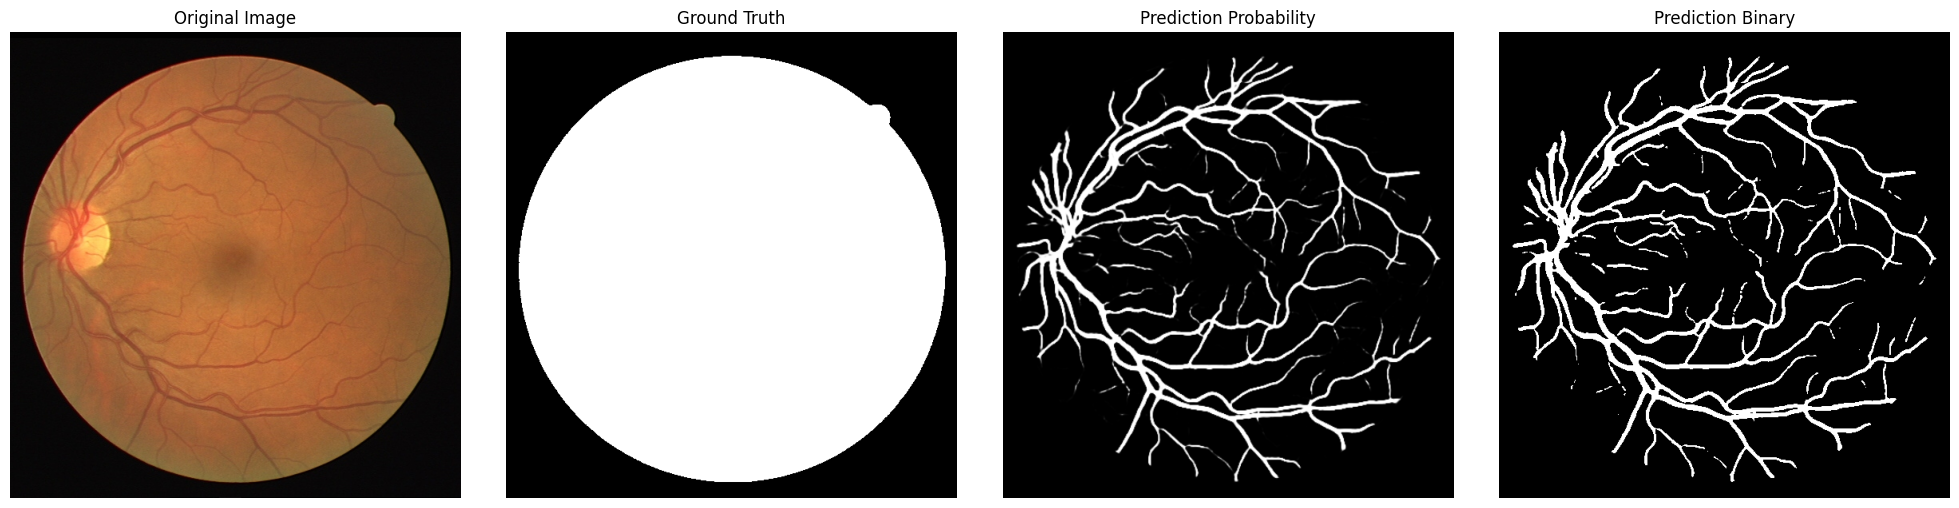

Results saved to /kaggle/working/improved_predictions


In [15]:
print("\n=== TESTING ON SAMPLE IMAGE ===")
if images_test:
    test_image_path = images_test[0]
    print(f"Segmenting test image: {os.path.basename(test_image_path)}")
    
    # Segment image
    segmented_mask_binary, segmented_prob_map = segment_full_image(test_image_path, model)
    
    if segmented_mask_binary is not None:
        # Load original image
        try:
            original_img_display = np.array(Image.open(test_image_path).convert('RGB'))
        except:
            original_img_display = np.zeros(segmented_mask_binary.shape + (3,), dtype=np.uint8)
        
        # Load ground truth if available
        if masks_test:
            try:
                gt_mask_orig = np.array(Image.open(masks_test[0]).convert('L'))
                gt_mask_display = (gt_mask_orig > 128).astype(np.uint8) * 255
            except Exception as e:
                print(f"Could not load ground truth: {e}")
                gt_mask_display = np.zeros_like(segmented_mask_binary, dtype=np.uint8)
        else:
            gt_mask_display = np.zeros_like(segmented_mask_binary, dtype=np.uint8)
        
        # Display results
        plt.figure(figsize=(20, 5))
        
        plt.subplot(1, 4, 1)
        plt.imshow(original_img_display)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(1, 4, 2)
        plt.imshow(gt_mask_display, cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')
        
        plt.subplot(1, 4, 3)
        plt.imshow(segmented_prob_map, cmap='gray')
        plt.title('Prediction Probability')
        plt.axis('off')
        
        plt.subplot(1, 4, 4)
        plt.imshow(segmented_mask_binary, cmap='gray')
        plt.title('Prediction Binary')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Save results
        output_folder = '/kaggle/working/improved_predictions'
        os.makedirs(output_folder, exist_ok=True)
        
        output_binary = os.path.join(output_folder, 'prediction_binary.png')
        output_prob = os.path.join(output_folder, 'prediction_prob.png')
        
        cv2.imwrite(output_binary, segmented_mask_binary)
        cv2.imwrite(output_prob, (segmented_prob_map * 255).astype(np.uint8))
        
        print(f"Results saved to {output_folder}")

# Example Usage: Segment a Test Image 


=== TRAINING HISTORY ===


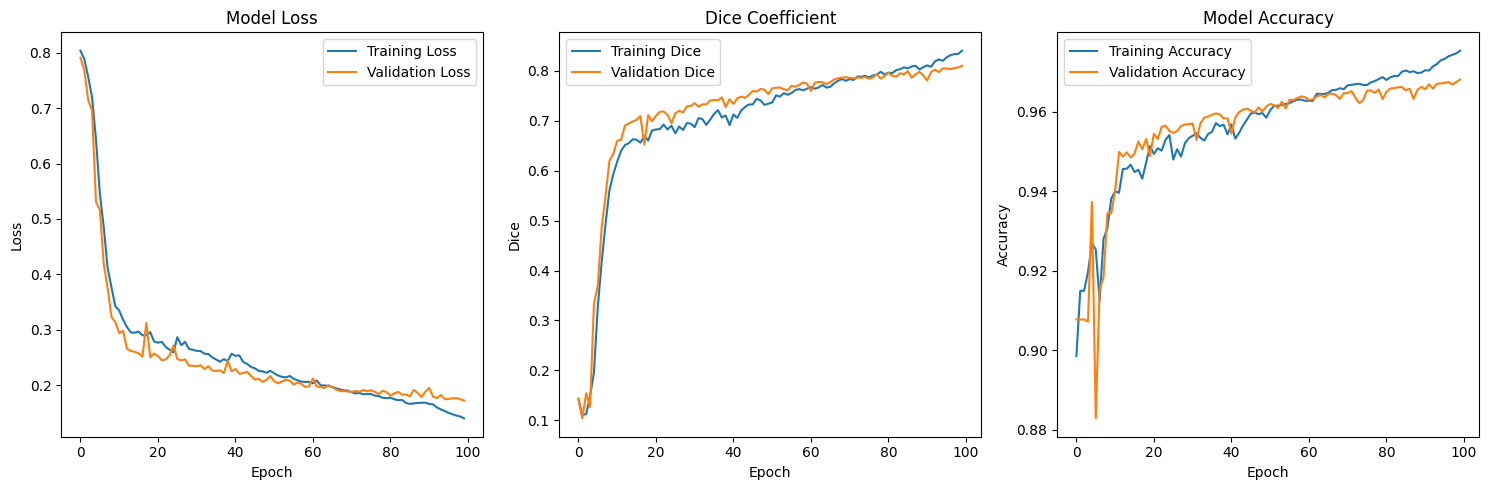


=== TRAINING COMPLETED ===
Model saved to: /kaggle/working/best_vessel_model.keras


In [16]:
print("\n=== TRAINING HISTORY ===")
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['dice_coefficient'], label='Training Dice')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print("\n=== TRAINING COMPLETED ===")
print("Model saved to: /kaggle/working/best_vessel_model.keras")